In [ ]:
! pip install numpyro corner healpy einops reproject

In [2]:
# run only if LaTeX is needed
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript javascript-common
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libharfbuzz-icu0 libidn11
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpdfbox-java
  libptexenc1 libruby2.7 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data preview-latex-style
  rake ruby ruby-minitest ruby-net-telnet ruby-power-assert ruby-test-unit
  ruby-xmlrpc ruby2.7 rubygems-integration t1utils tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fon

In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r'/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/')
%cd /content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks

Mounted at /content/drive
/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks


In [4]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('matplotlibrc')

## 0. Load model

In [5]:
from models.poissonian import EbinPoissonModel

In [6]:
ebinmodel = EbinPoissonModel(nside=128)

In [7]:
output_dir = '../output/posteriors'

## 1. Compare different fitting methods

### 1.1 Stochastic Variational Inference (SVI)
Takes $\sim$2 minutes to run on a V100.

In [ ]:
ebinmodel.config_model(ebin=10)
svi_results = ebinmodel.fit_SVI(
    rng_key=jax.random.PRNGKey(4242),
    guide='iaf', num_flows=5, hidden_dims=[128, 128],
    n_steps=10000, lr=5e-5, num_particles=8,
    ebin=10,
)

In [ ]:
samples = ebinmodel.get_svi_samples(num_samples=50000)
pickle.dump((samples, svi_results), open(f'{output_dir}/check_SVI/ebin10_smp_svi.p', 'wb'))

### 1.2 Parallel Tempering Hamiltonian Monte Carlo (PTHMC)
With or without neutral transport (neutra). $\sim$20 minutes to run on a V100. \
To use neutra, must run SVI first.

In [ ]:
from jax.config import config
config.update('jax_enable_x64', True)

In [ ]:
ebinmodel.run_parallel_tempering_hmc(num_samples=50000, use_neutra=False)

In [ ]:
samples = ebinmodel.expand_samples(ebinmodel.pt_mcmc.get_samples())
pickle.dump(samples, open(f"{output_dir}/check_SVI/ebin10_pthmc.p", 'wb'))

### 1.3 Maximum a Posteriori (MAP)
Point estimate with prior folded in. $\sim$ 1 minute to run. Uses SVI with a delta function $\delta^n(\theta-\theta_0)$ guide, where $n$ is the number of dimensions of the fit.

In [ ]:
svi_results = ebinmodel.fit_MAP(n_steps=30000, ebin=10)

In [ ]:
ebinmodel.MAP_estimates['f_blg'] = ebinmodel.MAP_estimates['S_blg'] / (ebinmodel.MAP_estimates['S_blg'] + ebinmodel.MAP_estimates['S_nfw'])
pickle.dump(
    (ebinmodel.expand_samples(ebinmodel.MAP_estimates), svi_results),
    open(f'{output_dir}/check_SVI/ebin10_MAP.p', 'wb'),
)

### 1.4 compare

In [8]:
from utils.plotting import multi_corner

In [ ]:
samples_dict = {
    'SVI 1' : pickle.load(open(f'{output_dir}/check_SVI/ebin10_smp_svi.p', 'rb'))[0],
    'SVI 2' : pickle.load(open(f'{output_dir}/check_SVI/ebin10_smp_svi_2.p', 'rb'))[0],
    'SVI 3' : pickle.load(open(f'{output_dir}/check_SVI/ebin10_smp_svi_3.p', 'rb'))[0],
    'PTHMC NT' : pickle.load(open(f'{output_dir}/check_SVI/ebin10_pthmc_nt.p', 'rb')),
    'PTHMC' : pickle.load(open(f'{output_dir}/check_SVI/ebin10_pthmc.p', 'rb')),
}
MAP = pickle.load(open(f'{output_dir}/check_SVI/ebin10_MAP.p', 'rb'))[0]
colors_dict = {
    'SVI 1' : mpl.colormaps['viridis'](0.6),
    'SVI 2' : mpl.colormaps['viridis'](0.7),
    'SVI 3' : mpl.colormaps['viridis'](0.8),
    'PTHMC NT' : mpl.colormaps['binary'](0.9),
    'PTHMC' : mpl.colormaps['binary'](0.5),
}
labels_dict = {
    'SVI 1' : 'SVI run 1',
    'SVI 2' : 'SVI run 2',
    'SVI 3' : 'SVI run 3',
    'PTHMC NT' : 'PTHMC with NeuTra',
    'PTHMC' : 'PTHMC',
}
plot_var_names = [
    'S_iso', 'S_nfw', 'S_blg', 'f_blg', 'gamma', 'S_pib', 'S_ics',
    'theta_pib_modelo', 'theta_blg_coleman2019',
]

multi_corner(
    samples_dict, plot_var_names, MAP=MAP,
    colors_dict=colors_dict, labels_dict=labels_dict,
    #save_fn=f"{output_dir}/plots/compare_SVI.pdf",
)

## 2. SVI for all energy bins

In [ ]:
for ie in range(10, 20):
    print('ebin: ', ie)
    ebinmodel.config_model(ebin=ie)
    svi_results = ebinmodel.fit_SVI(
        rng_key=jax.random.PRNGKey(42),
        guide="iaf", num_flows=5, hidden_dims=[128, 128],
        n_steps=10000, lr=5e-5, num_particles=16,
        ebin=ie,
    )
    samples = ebinmodel.get_svi_samples(num_samples=50000)
    pickle.dump((samples, svi_results), open(f'{output_dir}/test_bin{ie}.p', 'wb'))

## 3. View

In [ ]:
samples_dict = {
    str(ie) : pickle.load(open(f'{output_dir}/ebin/test_bin{ie}.p', 'rb'))[0]
    for ie in range(10, 20)
}
for k, s in samples_dict.items():
    s['S_blg'] = np.clip(s['S_blg'], None, 1.)
    s['S_pib'] = np.clip(s['S_pib'], None, 5.)
    s['S_ics'] = np.clip(s['S_ics'], None, 5.)
    if 'auto_shared_latent' in s:
        s.pop('auto_shared_latent')
        
colors_dict = {
    str(ie) : mpl.colormaps['rainbow']((ie-10)/9)
    for ie in range(10, 20)
}
plot_var_names = [
    'S_iso', 'S_nfw', 'S_blg', 'f_blg', 'gamma', 'S_pib', 'S_ics',
    'theta_pib_modelo', 'theta_blg_macias2019', 'theta_blg_coleman2019',
]

multi_corner(
    samples_dict, plot_var_names,
    colors_dict=colors_dict, save_fn=f"{output_dir}/plots/ebin_fit.pdf"
)

## 4. Adding custom gas/ICS/bulge templates
Format:
- (Energy binned) Healpix map in shape (n_ebin, n_pix)
- nside should be greater than fit nside
- Energy dependence covers, if applicable, should cover 2-20 GeV. Our binning is from 0.2-2000 GeV, in 40 log uniform bins. We could fit in every energy, but we concentrate on 2-20 GeV (bin 10-19).
- Fitted normalization fraction will appear as `theta_pib_mymodel` and `theta_ics_mymodel`.

In [26]:
from templates.rigid_templates import EbinTemplate
from utils.map_utils import to_nside

In [27]:
print('Diffuse models in use:', ebinmodel.dif_names)
ebin_edges = np.geomspace(0.2, 2000, 40+1) # [GeV]
ebins = np.sqrt(ebin_edges[:-1]*ebin_edges[1:]) # geometric centers
print('Energy bin edges used in our fit:\n', ebin_edges[10:21])

Diffuse models in use: ['ccwa', 'ccwf', 'modelo']
Energy bin edges used in our fit:
 [ 2.          2.51785082  3.16978638  3.99052463  5.02377286  6.32455532
  7.96214341 10.02374467 12.61914689 15.88656469 20.        ]


Now is time to add the templates. Below is a simple interpolation tool.

In [ ]:
# custom model
my_engs =  # (n_ebin,)
my_temps =  # (n_ebin, n_pix)

# interpolate to this notebook's binning
from templates.rigid_templates import interp1d
my_temps_interp = []
for eng in ebins:
    my_temps_interp.append(interp1d(eng, my_engs, my_temps))
my_temps_interp = jnp.array(my_temps_interp)

In [ ]:
# Example: adding energy dependent gas/ICS models
ebinmodel.dif_names.append('mymodel')
ebinmodel.n_dif_temps = len(ebinmodel.dif_names)
ebinmodel.pib_temps.append(
    EbinTemplate(
        to_nside("pibrem model goes here", ebinmodel.nside),
        norm_mask=ebinmodel.normalization_mask,
    )
) # ebinmodel.model will create a random variable called theta_pib_mymodel
ebinmodel.ics_temps.append(
    EbinTemplate(
        to_nside("ics model goes here", ebinmodel.nside),
        norm_mask=ebinmodel.normalization_mask,
    )
) # ebinmodel.model will create a random variable called theta_ics_mymodel

In [ ]:
# Example: adding energy independent bulge models
ebinmodel.blg_names.append('mybulgemodel')
ebinmodel.n_blg_temps = len(ebinmodel.blg_names)
ebinmodel.blg_temps.append(
    Template(
        to_nside("bulge model goes here", ebinmodel.nside),
        norm_mask=ebinmodel.normalization_mask,
    )
) # ebinmodel.model will create a random variable called theta_blg_mymodel

# Appendix

## A1. view

In [ ]:
from utils.cart import to_cart

In [ ]:
n_pixels = 80
pixelsize = 0.5

mask_roi_cart = to_cart(ebinmodel.mask_rois[10], n_pixels=n_pixels, pixelsize=pixelsize) > 0

In [ ]:
plt.imshow(mask_roi_cart)

## A2. Maximum Likelihood Estimate (MLE)
Likelihood only point estimates (defunct).

In [ ]:
results = []
methods = ['scipy minimize', 'scipy shgo', 'jax.scipy minimize']
for method in methods:
    print(method)
    results.append(ebinmodel.fit_MLE_at_bin(15, method=method))

scipy minimize
scipy shgo
jax.scipy minimize


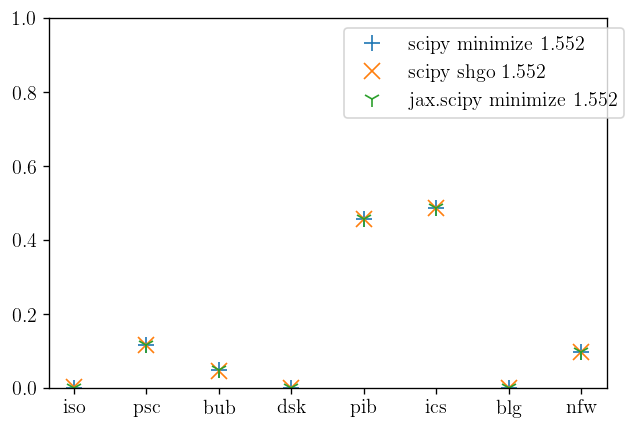

In [ ]:
m_s = ['+', 'x', '1']

fig, ax = plt.subplots()
for method, result, m in zip(methods, results, m_s):
    ax.plot(np.exp(result.x), marker=m, ls='None', ms=10, label=method+f' {result.fun:.3f}')

ax.set(ylim=(0,1))
ax.set_xticks(list(range(8)))
ax.set_xticklabels(['iso', 'psc', 'bub', 'dsk', 'pib', 'ics', 'blg', 'nfw'])
ax.legend(bbox_to_anchor=(1.05, 1.0));